# Anomaly Detection

In [44]:
import tensorflow as tf

In [45]:
import keras

In [46]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Input,Dropout
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=10,6
RANDOM_SEED=42
LABELS=['Severity','Non Severity']

In [48]:
#load the data
df=pd.read_csv('Diseasesdt.csv')
df.head()


,Tiredness,Dry-Cough,Sore-Throat,Age_0-9,Severity,Non Severity
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,0,0
3,1,1,1,1,1,0
4,1,1,1,1,1,0


In [49]:
df.shape

(316800, 6)

# Checking the missing values

In [50]:
df.isnull().values.any()

False

In [51]:
df.isna().sum().sum()


0

# Building Autoencoder Model


In [52]:
xtrain,xtest=train_test_split(df,test_size=0.2,random_state=RANDOM_SEED)

In [53]:
input_dim=xtrain.shape[1]
encoding_dim=14

In [54]:
input_layer=Input(shape=(input_dim,))
encoder=Dense(encoding_dim,activation='tanh',
              activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(int(encoding_dim/2),activation='relu')(encoder)
decoder=Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)


In [55]:
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_4 (Dense)             (None, 14)                98        
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
 dense_7 (Dense)             (None, 6)                 48        
                                                                 
Total params: 307 (1.20 KB)
Trainable params: 307 (1.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
from keras.models import load_model
autoencoder=load_model('model_ae.h5')


# Evaluation

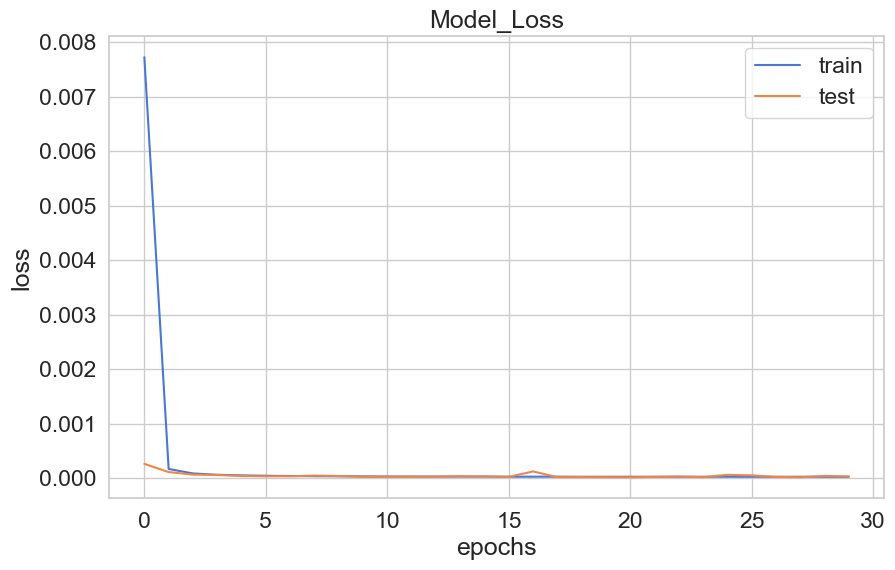

In [58]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper right')

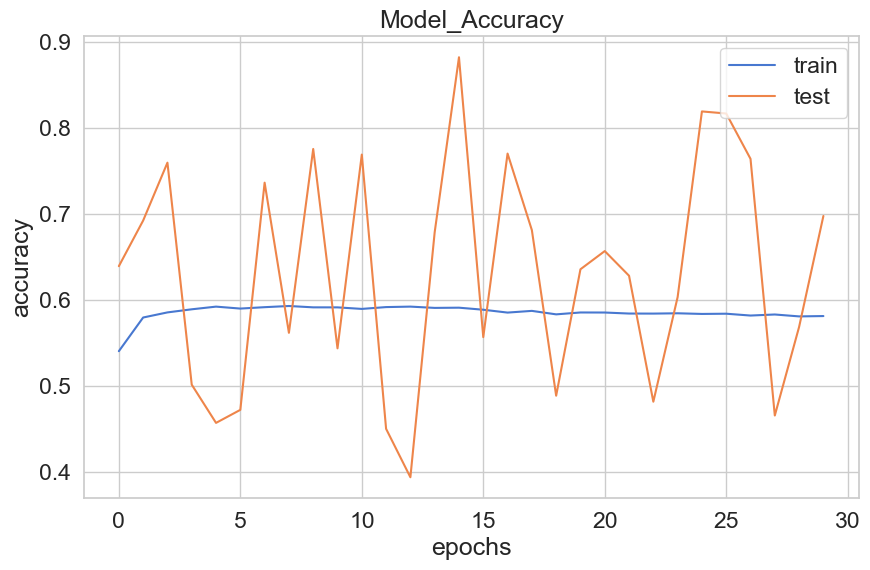

In [59]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model_Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper right')

In [60]:
predictions=autoencoder.predict(xtest)

1980/1980 [==============================] - 2s 921us/step


(63360, 6)

In [63]:
mse=np.mean(np.power(xtest-predictions,2),axis=1)
error_df=pd.DataFrame({'Reconstruction_error':mse,'Severity':ytest})
error_df

,Reconstruction_error,Severity
277936,1.907753e-06,1
193502,1.208074e-06,0
92446,6.512706e-06,0
117607,2.566672e-09,0
240924,1.215512e-06,0
...,...,...
122340,5.737889e-08,0
151370,2.566672e-09,0
288434,1.208074e-06,0
1619,5.379742e-06,0


In [64]:
# Assuming you have a DataFrame 'df' with a column 'Severity' containing your class labels
y = df['Severity'].values

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42  # Replace with your desired random seed
xtrain, xtest, ytrain, ytest = train_test_split(df.drop('Severity', axis=1), y, test_size=0.2, random_state=RANDOM_SEED)

In [65]:
# Assuming you have this line in your code
error_df = pd.DataFrame({'Reconstruction_error': mse, 'Severity': ytest})

# Now you can use error_df
print(error_df)

        Reconstruction_error  Severity
277936          1.907753e-06         1
193502          1.208074e-06         0
92446           6.512706e-06         0
117607          2.566672e-09         0
240924          1.215512e-06         0
...                      ...       ...
122340          5.737889e-08         0
151370          2.566672e-09         0
288434          1.208074e-06         0
1619            5.379742e-06         0
68501           4.841540e-06         1

[63360 rows x 2 columns]


In [66]:
error_df

,Reconstruction_error,Severity
277936,1.907753e-06,1
193502,1.208074e-06,0
92446,6.512706e-06,0
117607,2.566672e-09,0
240924,1.215512e-06,0
...,...,...
122340,5.737889e-08,0
151370,2.566672e-09,0
288434,1.208074e-06,0
1619,5.379742e-06,0


In [67]:
error_df.describe()

,Reconstruction_error,Severity
count,6.336000e+04,63360.000000
mean,1.381999e-06,0.251089
std,1.739678e-06,0.433643
min,0.000000e+00,0.000000
25%,1.241594e-07,0.000000
50%,8.272623e-07,0.000000
75%,1.560599e-06,1.000000
max,7.779945e-06,1.000000


# Reconstruction error without Severity

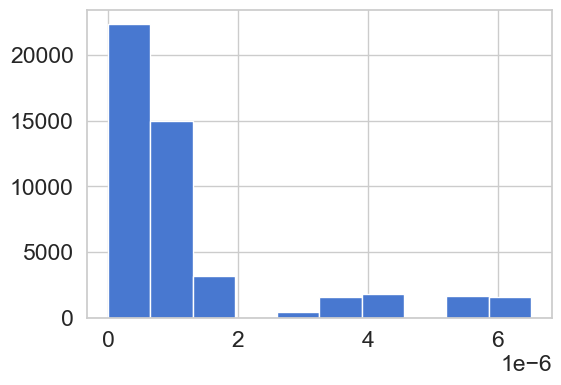

In [68]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
normal_error_df=error_df[(error_df['Severity']==0) & (error_df['Reconstruction_error']<1000)]
_=ax.hist(normal_error_df.Reconstruction_error.values,bins=10)


# Reconstruction error with Severity

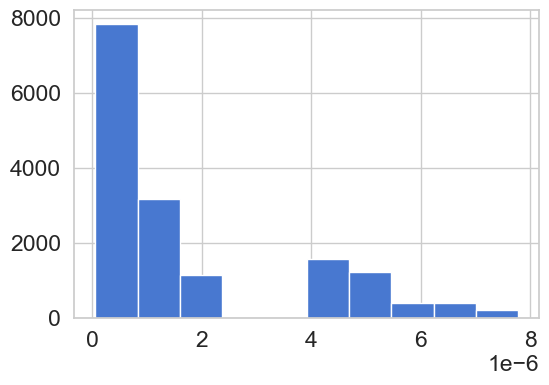

In [69]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
fraud_error_df=error_df[(error_df['Severity']==1)]
_=ax.hist(fraud_error_df.Reconstruction_error.values,bins=10)


In [70]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import precision_recall_curve,auc,roc_curve,recall_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

# ROC

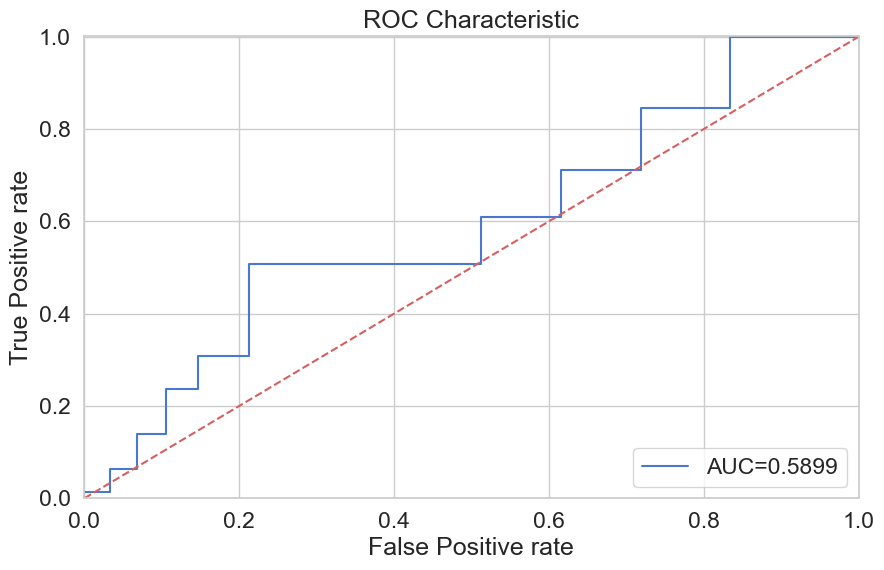

In [71]:
fpr,tpr,thresholds=roc_curve(error_df.Severity,error_df.Reconstruction_error)
roc_auc=auc(fpr,tpr)
plt.title('ROC Characteristic')
plt.plot(fpr,tpr,label='AUC=%0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()


# Recall Vs Precision

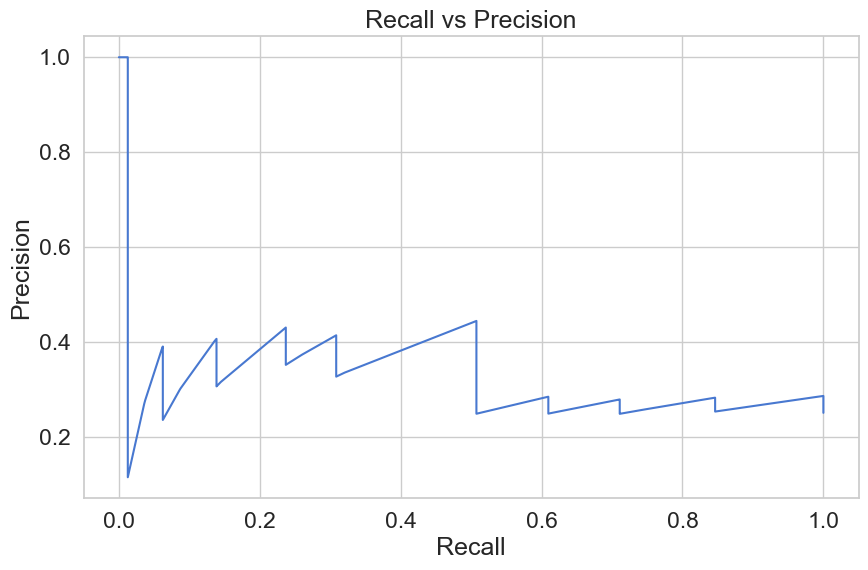

In [72]:
precision,recall,th=precision_recall_curve(error_df.Severity,error_df.Reconstruction_error)
plt.plot(recall,precision,'b',label='precision-recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


# Precision vs threshold

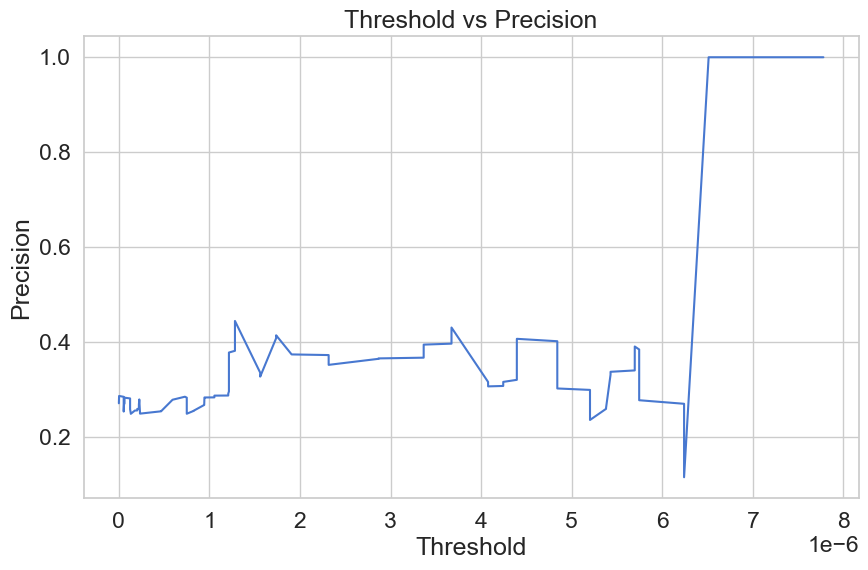

In [73]:
precision,recall,th=precision_recall_curve(error_df.Severity,error_df.Reconstruction_error)
plt.plot(th,precision[1:],'b',label='Threshold-precision curve')
plt.title('Threshold vs Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()


# Reconstruction_Error Vs Recall


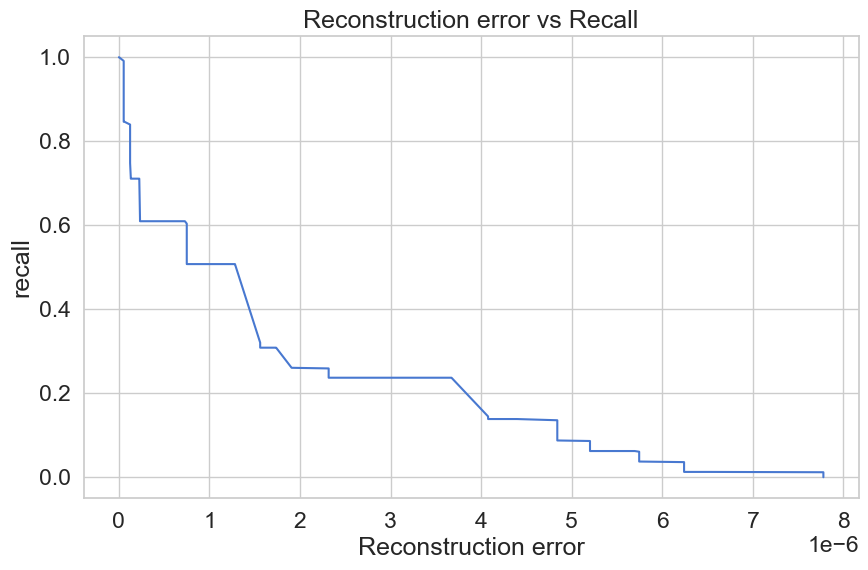

In [74]:
plt.plot(th,recall[1:],'b',label='Threshold-recall curve')
plt.title('Reconstruction error vs Recall')
plt.xlabel('Reconstruction error')
plt.ylabel('recall')
plt.show()


# Prediction

In [75]:
threshold=2.9

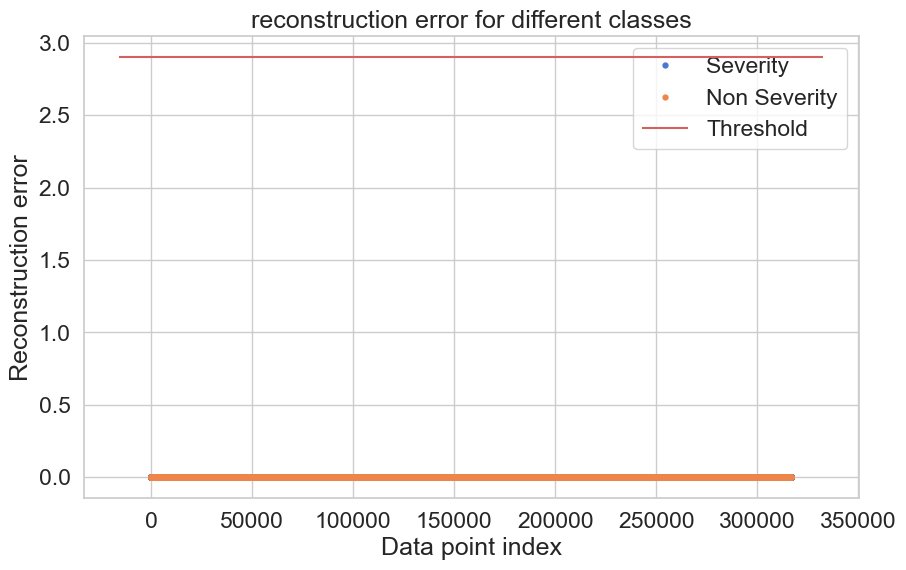

In [76]:
groups=error_df.groupby('Severity')
fig,ax=plt.subplots()
for name,group in groups:
    ax.plot(group.index,group.Reconstruction_error,marker='o',ms=3.5,linestyle='',
           label='Non Severity' if name ==1 else 'Severity')
ax.hlines(threshold,ax.get_xlim()[0],ax.get_xlim()[1],colors='r',zorder=100,label='Threshold')
ax.legend()
plt.title('reconstruction error for different classes')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.show()


# Confusion Matrix

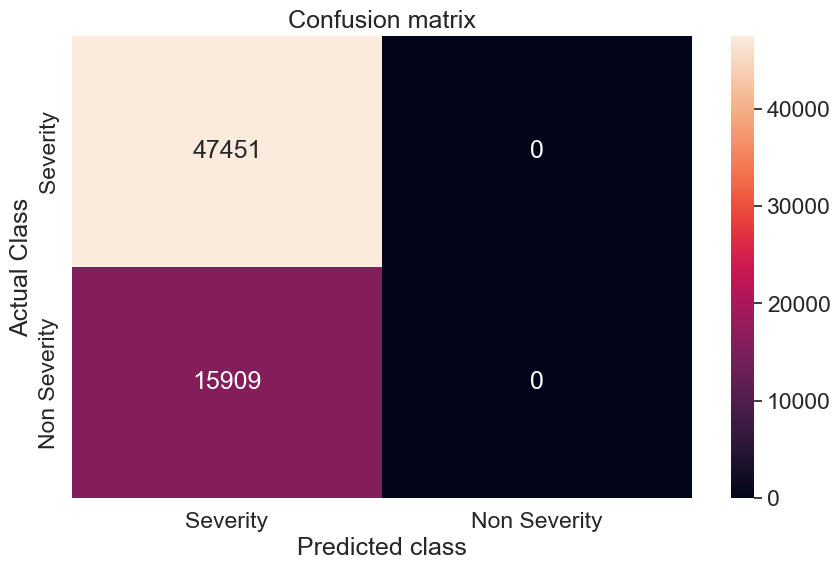

In [77]:
ypred=[1 if e>threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix=confusion_matrix(error_df.Severity,ypred)
sns.heatmap(conf_matrix,annot=True,xticklabels=LABELS,yticklabels=LABELS,fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual Class')
plt.show()
